In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors

import constants
import pandas as pd
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

vhr.plot.VisualizeParams.renderer = 'vscode' 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
from numpy.lib.arraysetops import isin
import pandas as pd
import numpy as np
from importlib import import_module, util
from pyVHR.datasets.dataset import datasetFactory
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from inspect import getmembers, isfunction
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
# import dtaidistance
import dtw
import scipy
from itertools import chain, combinations
import steps

from tqdm import tqdm

In [3]:
# -- LOAD A DATASET

dataset_name = 'lgi_ppgi' 
brightness = '140'
SAMPLING = '2000'
videoFPS, sigFPS = constants.get_fps(dataset_name)

dataset = steps.get_dataset(dataset_name)
# dataset = steps.get_dataset(dataset_name, video_DIR=f'D:/datasets_rppg/brightness_{brightness}/{dataset_name.upper()}')
allvideo = dataset.videoFilenames
videos = constants.get_video_settings(dataset_name)
print(videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

{'GYM': array([ 0,  4,  8, 12, 16, 20]), 'STILL': array([ 1,  5,  9, 13, 17, 21]), 'ROTATION': array([ 2,  6, 10, 14, 18, 22]), 'TALK': array([ 3,  7, 11, 15, 19]), 'MALE': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23]), 'FEMALE': [0, 1, 2, 3], 'BEARD': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23]), 'GLASSES': [0, 1, 2, 3]}
0 D:/datasets_rppg/lgi_ppgi\alex\alex_gym\cv_camera_sensor_stream_handler.avi
1 D:/datasets_rppg/lgi_ppgi\alex\alex_resting\cv_camera_sensor_stream_handler.avi
2 D:/datasets_rppg/lgi_ppgi\alex\alex_rotation\cv_camera_sensor_stream_handler.avi
3 D:/datasets_rppg/lgi_ppgi\alex\alex_talk\cv_camera_sensor_stream_handler.avi
4 D:/datasets_rppg/lgi_ppgi\angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
5 D:/datasets_rppg/lgi_ppgi\angelo\angelo_resting\cv_camera_sensor_stream_handler.avi
6 D:/datasets_rppg/lgi_ppgi\angelo\angelo_rotation\cv_camera_sensor_stream_handler.avi


videoFileName :  D:/datasets_rppg/lgi_ppgi\alex\alex_gym\cv_camera_sensor_stream_handler.avi
Video frame rate:      25.0
Length of the video: 1:05 min, timesGT is 402 s
Signal frame rate is 60 fps for MR-NIRP and signal is  401.46666666666664 seconds worth


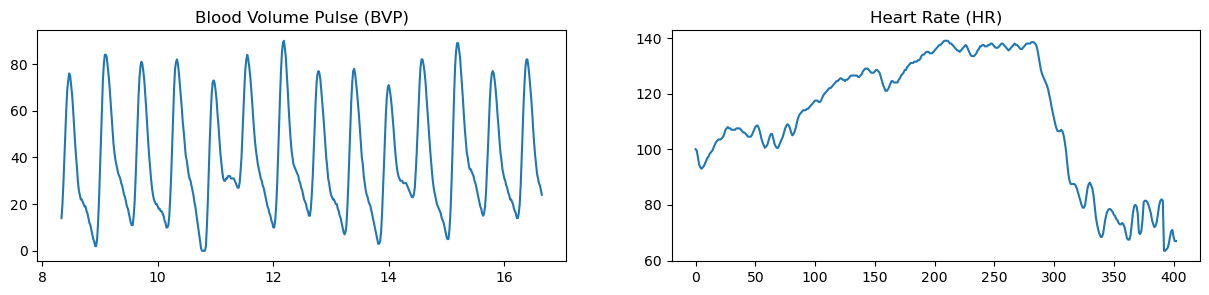

In [4]:
# -- PARAMETER SETTING

videoIdx = 0
winsize = 10        # seconds of video processed (with overlapping) for each estimate 
fname = dataset.getSigFilename(videoIdx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM
videoFileName = dataset.getVideoFilename(videoIdx)
fps = vhr.extraction.get_fps(videoFileName)
print("videoFileName : ", videoFileName)

fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print("Signal frame rate is 60 fps for MR-NIRP and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

# Extract windows

In [44]:
winsize = 10
overlap = 0 
duration = 60

In [45]:
# df = pd.read_hdf(f'../results/no_overlap/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df')
df = pd.read_hdf(f'../results/brightness_{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_roi/{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_rPPG_talk.h5', key='df')


print(f"Single landmark: {df['landmark'].unique().size}")
print(f"Dataset {df['dataset'].unique()} with {df['videoFilename'].unique().size} files" )
print("Sampling: ", SAMPLING, df['sampling'].unique()) 
print("Extracted video lenghth: ", len(df.loc[0, 'rPPG']) / videoFPS, "seconds")
df.head()

Single landmark: 28
Dataset ['ubfc_phys'] with 56 files
Sampling:  2000 [2000]
Extracted video lenghth:  59.76435767545108 seconds


,dataset,videoIdx,videoFilename,landmark,bpmGT,rPPG,timesGT,timesES,sampling
305,ubfc_phys,0,s1,chin,"[55.49999999999999, 56.5, 57.0, 44.0, 43.0, 39...","[[[165.7315, 126.9615, 94.0715]], [[166.803, 1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
283,ubfc_phys,0,s1,glabella,"[55.49999999999999, 56.5, 57.0, 44.0, 43.0, 39...","[[[179.753, 140.5565, 105.9105]], [[180.619, 1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
287,ubfc_phys,0,s1,left_ala,"[55.49999999999999, 56.5, 57.0, 44.0, 43.0, 39...","[[[174.03922, 121.07298, 81.62636]], [[174.011...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
303,ubfc_phys,0,s1,left_lower_cheek,"[55.49999999999999, 56.5, 57.0, 44.0, 43.0, 39...","[[[162.7535, 127.515, 84.555]], [[163.0335, 12...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
281,ubfc_phys,0,s1,left_lower_lateral_forehead,"[55.49999999999999, 56.5, 57.0, 44.0, 43.0, 39...","[[[171.519, 133.244, 91.6345]], [[171.6835, 13...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000


In [46]:
class TestResult():
    """ 
    This class manages the results on a given dataset using multiple rPPG methods.
    """

    def __init__(self, filename=None):

        if filename == None:
            self.dataFrame = pd.DataFrame()
        else:
            self.dataFrame = pd.read_hdf(filename)
        self.dict = None

    def addDataSerie(self):
        # -- store serie
        if self.dict != None:
            self.dataFrame = self.dataFrame._append(self.dict, ignore_index=True)
            # self.dataFrame = self.dataFrame.append(self.dict, ignore_index=True)

    def newDataSerie(self):
        # -- new dict
        D = {}
        D['method'] = ''
        D['dataset'] = ''
        D['videoIdx'] = ''        # video filename
        D['videoFilename'] = ''   # GT signal filename
        D['bpmGT'] = ''             # GT bpm
        D['bpmES'] = ''
        D['timeGT'] = ''            # GT bpm
        D['timeES'] = ''
        D['BVP_win'] = ''
        D['landmarks'] = ''
        self.dict = D


    def addData(self, key, value):
        self.dict[key] = value

    def saveResults(self, outFilename=None):
        """
        Save the test results in a HDF5 library that can be opened using pandas.
        You can analyze the results using :py:class:`pyVHR.analysis.stats.StatAnalysis`
        """
        if outFilename is None:
            outFilename = "testResults.h5"
        else:
            self.outFilename = outFilename

        # -- save data
        self.dataFrame.to_hdf(outFilename, key='self.dataFrame', mode='w')

def get_bpm(res, videoFileName, landmarks, windowed_sig,
            timesES, bpmGT, timesGT, PPG_win, videoFPS, sigFPS, dataset_name,
            cuda=True, 
            roi_method='convexhull', 
            roi_approach='landmark', 
            methods=['cupy_CHROM', 'cpu_LGI'], 
            estimate='median', 
            movement_thrs=[10, 5, 2],
            patch_size=30, 
            RGB_LOW_HIGH_TH = (0,240),
            Skin_LOW_HIGH_TH = (0, 240),
            pre_filt=True, 
            post_filt=True, 
            winsize = 10,
            verb=False):
    
    minHz = 0.65
    maxHz = 4.0
    fps = videoFPS

    ## 5. PRE FILTERING
    filtered_windowed_sig = windowed_sig

    if pre_filt:
        module = import_module('pyVHR.BVP.filters')
        method_to_call = getattr(module, 'BPfilter')
        filtered_windowed_sig = apply_filter(filtered_windowed_sig,
                                                method_to_call, 
                                                fps=fps, 
                                                params={'minHz':minHz, 
                                                        'maxHz':maxHz, 
                                                        'fps':'adaptive', 
                                                        'order':6})

    ## 6. BVP extraction multimethods
    bvps_win = []
    for method in methods:
        # try:
        if verb:
            print(" - Extraction method: " + method)
        module = import_module('pyVHR.BVP.methods')
        method_to_call = getattr(module, method)
        
        if 'cpu' in method:
            method_device = 'cpu'
        elif 'torch' in method:
            method_device = 'torch'
        elif 'cupy' in method:
            method_device = 'cuda'

        if 'POS' in method:
            pars = {'fps':'adaptive'}
        elif 'PCA' in method or 'ICA' in method:
            pars = {'component': 'all_comp'}
        else:
            pars = {}

        bvps_win = RGB_sig_to_BVP(filtered_windowed_sig, 
                                fps, device_type=method_device, 
                                method=method_to_call, params=pars)

        ## 7. POST FILTERING
        if post_filt:
            module = import_module('pyVHR.BVP.filters')
            method_to_call = getattr(module, 'BPfilter')
            bvps_win = apply_filter(bvps_win, 
                                method_to_call, 
                                fps=fps, 
                                params={'minHz':minHz, 'maxHz':maxHz, 'fps':'adaptive', 'order':6})

        ## 8. BPM extraction

        if roi_approach == 'holistic':
            if cuda:
                bpmES = BVP_to_BPM_cuda(bvps_win, fps, minHz=minHz, maxHz=maxHz)
            else:
                bpmES = BVP_to_BPM(bvps_win, fps, minHz=minHz, maxHz=maxHz)

        elif roi_approach == 'patches' or roi_approach == 'landmark':
            if estimate == 'clustering':
                #if cuda and False:
                #    bpmES = BVP_to_BPM_PSD_clustering_cuda(bvps_win, fps, minHz=minHz, maxHz=maxHz)
                #else:
                #bpmES = BPM_clustering(sig_processing, bvps_win, winsize, movement_thrs=[15, 15, 15], fps=fps, opt_factor=0.5)
                ma = MotionAnalysis(sig_processing, winsize, fps)
                bpmES = BPM_clustering(ma, bvps_win, fps, winsize, movement_thrs=movement_thrs, opt_factor=0.5)
                
            elif estimate == 'median':
                if cuda:
                    bpmES = BVP_to_BPM_cuda(bvps_win, fps, minHz=minHz, maxHz=maxHz)
                else:
                    bpmES = BVP_to_BPM(bvps_win, fps, minHz=minHz, maxHz=maxHz)
        else:
            raise ValueError("Estimation approach unknown!")
        
        # -- save results
        res.newDataSerie()
        res.addData('method', str(method))
        res.addData('bpmGT', bpmGT)
        res.addData('bpmES', bpmES) # before aggregating of left and right
        res.addData('timeGT', timesGT)
        res.addData('timeES', timesES)
        res.addData('BVP_win', bvps_win)
        res.addData('videoFilename', videoFileName)
        res.addData('landmarks', tuple(landmarks))
        res.addDataSerie()
        
    return res, bvps_win

In [47]:
case = 'each_28'
all_landmarks, landmarks_keys = steps.get_landmarks(case)

In [48]:
import steps 
res = TestResult()

# for videoIdx in tqdm(range(len(allvideo))):
# for fileIdx in tqdm(videos['STILL']):
for videoIdx in tqdm(df.videoIdx.unique()):
# for fileIdx in tqdm(videos['STILL'][:1]):
    try:
        # videoIdx = allvideo.index(allvideo[fileIdx])
        fps = get_fps(allvideo[videoIdx])
        PPG_win, bpmGT, timesGT, videoFileName = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize)
    except Exception as e:
        print(f"Error in {videoIdx} {videoFileName}: {e}")
        continue

    # for landmarks in all_landmarks[:2]:
    for landmarks in all_landmarks:
        try:        
            # timesES = df.loc[df['videoFilename'] == videoFileName, 'timesES'].iloc[0]
            # rppgs = df.loc[(df['videoFilename'] == videoFileName) & (df['landmark'].isin(landmarks)), 'rPPG_windowed',].tolist()
            rppgs = df.loc[(df['videoFilename'] == videoFileName) & (df['landmark'].isin(landmarks)), 'rPPG',].tolist()
            for i,rppg in enumerate(rppgs): # windowing
                rppgs[i], timesES = steps.sig_windowing(rppgs[i], winsize, winsize-overlap, fps)

            windowed_sig = np.concatenate([rppg for rppg in rppgs], axis=1)
            windowed_sig = windowed_sig[:int(duration/winsize)] # only take duration length, here 60s
            timesES = timesES[:int(duration/winsize)] # only take duration length, here 60s
            # print("Selected landmarks: ", landmarks)
            # print("Selected RPPG: ", len(rppgs), len(rppgs[0]), rppgs[0][0].shape) # nb_tests, seconds, (nb_landmarks==1, RGB, nb_frames 240)
            # print("windowed_sig: ", windowed_sig.shape)  #(seconds, nb_tests, RGB, nb_frames 240)

            res, _ = get_bpm(res, videoFileName, landmarks, windowed_sig, timesES, bpmGT, timesGT, PPG_win, fps, sigFPS, dataset_name, roi_approach='landmark', methods=['cupy_CHROM'])
        except Exception as e:
            print(f"Error in {videoIdx} {videoFileName}: {e}")
            continue
            
res.dataFrame['dataset'] = dataset_name
    

100%|██████████| 56/56 [01:05<00:00,  1.16s/it]


In [49]:
df_res = res.dataFrame
rois = constants.get_rois()
for roi in list(rois.keys()):
    df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi

indexes = {}
for v in range(len(allvideo)):
  if dataset_name == 'lgi_ppgi':
    indexes[allvideo[v].split('\\')[-2]] = v
  elif dataset_name == 'ubfc_phys':
    if 'T1' not in allvideo[v]: continue  
    indexes[allvideo[v].split('\\')[-1].split('_')[1]] = v 
  elif dataset_name == 'mr_nirp':
    indexes[allvideo[v].split('\\')[-1][:-4]] = v
indexes = pd.DataFrame({'videoIdx':list(indexes.values()), 'videoFilename':list(indexes.keys())})
df_res = df_res.drop(columns=['videoIdx'])
df_res.insert(3, 'videoIdx', df_res['videoFilename'].map(indexes.set_index('videoFilename')['videoIdx']))

df_res['SAMPLING'] = SAMPLING
df_res['winsize'] = winsize
df_res['overlap'] = overlap
print(f"Single landmark: {df_res['landmarks'].unique().size}")
print(f"Dataset {df_res['dataset'].unique()} with {df_res['videoFilename'].unique().size} files" )
df_res.head()

Single landmark: 28
Dataset ['ubfc_phys'] with 56 files


C:\Users\erolland\AppData\Local\Temp\2\ipykernel_26228\150667606.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'forehead' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi


,method,dataset,videoFilename,videoIdx,bpmGT,bpmES,timeGT,timeES,BVP_win,landmarks,ROI,SAMPLING,winsize,overlap
0,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[106.640625, 77.9296875, 66.650390625, 93.3105...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.018952393067930225, -0.9122664106130298, ...","(lower_medial_forehead,)",forehead,2000,10,0
1,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[68.701171875, 98.4375, 66.650390625, 75.87890...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.026564884640502134, -0.2843881475464263, ...","(left_lower_lateral_forehead,)",forehead,2000,10,0
2,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[67.67578125, 57.421875, 106.640625, 92.285156...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.017780451313233282, -0.24904690544399422,...","(right_lower_lateral_forehead,)",forehead,2000,10,0
3,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[68.701171875, 79.98046875, 66.650390625, 92.2...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.035322676984965294, -0.4654793280692958, ...","(glabella,)",forehead,2000,10,0
4,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[68.701171875, 78.955078125, 68.701171875, 62....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.02196518652740658, -0.12593610247785872, ...","(upper_nasal_dorsum,)",nose,2000,10,0


In [50]:
# path = f'../results/no_overlap/{dataset_name.upper()}/'
path = f'../results/brightness_{brightness}/{dataset_name.upper()}/'
# path = f'../results/brightness_roi/{brightness}/{dataset_name.upper()}/'

filenames = {'each_28':'28', 'each_18':'18', 'all_in_roi':'entire_ROI', 'combine_random_landmarks':'combine_2_landmarks', 'combine_roi_landmarks':'landmarks_in_roi', 'combine_roi':'combine_ROI'}
# filenames['combine_random_landmarks'] = f"combine_3-5_landmarks"
filename = path+f'{dataset_name.upper()}_BVP28.h5'

print(filename)
df_res.to_hdf(filename, key='df', mode='w')

../results/brightness_140/UBFC_PHYS/UBFC_PHYS_BVP28.h5


C:\Users\erolland\AppData\Local\Temp\2\ipykernel_26228\568808097.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['method', 'dataset', 'videoFilename', 'bpmGT', 'bpmES', 'timeGT',
       'timeES', 'BVP_win', 'landmarks', 'ROI', 'SAMPLING'],
      dtype='object')]

  df_res.to_hdf(filename, key='df', mode='w')


# Evaluate

In [8]:
duration = 30

In [46]:
elements = ['left_malar',
 'right_malar',
#  'left_ala',
#  'right_ala',
 'left_lower_cheek',
 'right_lower_cheek',
 'soft_triangle',
 'upper_nasal_dorsum',
 'lower_medial_forehead',
 'glabella',
#  'left_nasolabial_fold',
#  'right_nasolabial_fold',
 'left_lower_lateral_forehead',
 'right_lower_lateral_forehead',
#  'lower_nasal_dorsum',
 'chin',
#  'left_temporal', 
#  'right_temporal',
 'left_marionette_fold', 
 'right_marionette_fold'
 ]

In [47]:
elements = ['lower_lateral_forehead', 'marionette_fold', 'chin', 'lower_medial_forehead', 'upper_nasal_dorsum', 'soft_triangle', 'glabella', 'malar', 'lower_cheek', 'temporal']
t = steps.get_landmarks_combination(elements, min_len=2, max_len=5)
len(t)

627

In [9]:
# Landmarks choice
case = 'each_28'
cases = ['each_28', 'each_18', 'all_in_roi', 'combine_random_landmarks', 'combine_roi_landmarks', 'combine_roi']
# elements = sum([rois[roi] for roi in ['forehead', 'nose', 'cheeks',]], [])
if case == 'combine_random_landmarks':
    rois = constants.get_rois()
    all_landmarks_names = vhr.extraction.utils.CustomLandmarks().get_all_landmarks()
    elements = {i: all_landmarks_names[i] for i in elements}
    all_landmarks, landmarks_keys = steps.get_landmarks(case, min_len=2, max_len=5, all_landmarks_names=elements, rois=None)
else:
    all_landmarks, landmarks_keys = steps.get_landmarks(case)
print(f"Chosen_landmarks: {len(all_landmarks)}, {all_landmarks}")

# Check extraction configuration
config = f'{SAMPLING}_win10-0'
overlap = int(config[-1])
winsize = int(config.split('_')[1].split('-')[0][3:])
duration = 60
length = int((duration - winsize) / (winsize - overlap)) + 1
print(f"Overlap: {overlap}, Winsize: {winsize}, Duration: {duration}, Length: {length}")
print("Case: ", case)    

Chosen_landmarks: 28, [['lower_medial_forehead'], ['left_lower_lateral_forehead'], ['right_lower_lateral_forehead'], ['glabella'], ['upper_nasal_dorsum'], ['lower_nasal_dorsum'], ['soft_triangle'], ['left_ala'], ['right_ala'], ['nasal_tip'], ['left_lower_nasal_sidewall'], ['right_lower_nasal_sidewall'], ['left_mid_nasal_sidewall'], ['right_mid_nasal_sidewall'], ['philtrum'], ['left_upper_lip'], ['right_upper_lip'], ['left_nasolabial_fold'], ['right_nasolabial_fold'], ['left_temporal'], ['right_temporal'], ['left_malar'], ['right_malar'], ['left_lower_cheek'], ['right_lower_cheek'], ['chin'], ['left_marionette_fold'], ['right_marionette_fold']]
Overlap: 0, Winsize: 10, Duration: 60, Length: 6
Case:  each_28


In [13]:
df = pd.read_hdf(f'../results/no_overlap/{dataset_name.upper()}/{config}/{dataset_name.upper()}_BVP28_{config}.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_BVP28.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_roi/{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_BVP28_talk.h5', key='df')

df = df.query('method == "cupy_CHROM"').reset_index(drop=True)
df['RMSE'] = None
df['MAE'] = None
df['PCC'] = None
df['timePCC'] = None
df['timeDTW'] = None    
df['SNR'] = None
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(df.method.unique())
df.head(1)

['cupy_CHROM']


,method,dataset,videoFilename,videoIdx,bpmGT,bpmES,timeGT,timeES,BVP_win,landmarks,ROI,SAMPLING,winsize,overlap,RMSE,MAE,PCC,timePCC,timeDTW,SNR
0,cupy_CHROM,lgi_ppgi,alex_gym,0,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[50.537109375, 104.736328125, 126.708984375, 1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.033759601976551916, -0.8398029448840973,...","(lower_medial_forehead,)",forehead,2000,10,0,None,None,None,None,None,None


In [11]:
def add_data(landmarks, videoFileName, videoIdx, method, RMSE, MAE, PCC, CC, DTW, SNR, bpmGT, bpmES, timesGT, timesES, BVP_win, dataset_name):
  
  data = {}
  data['dataset'] = dataset_name
  data['videoIdx'] = videoIdx
  data['videoFilename'] = videoFileName
  data['method'] = method
  data['landmarks'] = tuple(landmarks) # single landmark
  data['bpmGT'] = bpmGT
  data['bpmES'] = bpmES
  data['timeGT'] = timesGT
  data['timeES'] = timesES
  data['BVP_win'] = BVP_win
  data['RMSE'] = RMSE 
  data['MAE'] = MAE
  data['PCC'] = PCC
  data['timePCC'] = CC
  data['timeDTW'] = DTW
  data['SNR'] = SNR

  return data

In [14]:
import dtaidistance as dtwai

dataset = steps.get_dataset(dataset_name, video_DIR=f'D:/datasets_rppg/brightness_{brightness}/{dataset_name.upper()}')
results = []
print("Landmarks: ", len(all_landmarks), case)

for videoIdx in tqdm(df.videoIdx.unique()):
# for fileIdx in tqdm(videos['STILL'][2:3]):
    try:
        # videoIdx = allvideo.index(allvideo[fileIdx])
        fps = get_fps(allvideo[videoIdx])
        PPG_win, bpmGT, timesGT, videoFileName = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize, winsize-overlap)

    except Exception as e:
        print(f"Error in GT {videoIdx} {videoFileName}: {e}")
        continue

    # for landmarks in all_landmarks[:2]:
    for landmarks in all_landmarks:
        # for method in df.method.unique():
        #     data = df.loc[df['method'] == method]
            try:        
                method = 'cupy_CHROM'
                data = df.loc[(df['videoFilename'] == videoFileName) & (df['landmarks'].apply(lambda x: x[0] in landmarks)), ['timeES', 'bpmES', 'BVP_win']]
                timesES, bpmES, BVP_win = data['timeES'].iloc[0], data['bpmES'].to_numpy(), data['BVP_win'].to_numpy()

                # Aggregate BVP and BPM
                BVP_agg = BVP_win
                for i,bvp_win in enumerate(BVP_win):
                    BVP_agg[i] = np.mean(bvp_win, axis=1) # take the mean in case the landmark is symmetrics
                BVP_agg = np.mean(BVP_agg, axis=0) # mean of all landmarks

                bpmES_agg = bpmES
                for i, bpm in enumerate(bpmES):
                    if np.array(bpm).ndim >1: # take the mean in case the landmark is symmetrics
                        bpmES_agg[i] = np.mean(bpm, axis=1)
                    else: # need to reduce the dimension
                        bpmES_agg[i] = np.array(bpm)
                bpmES_agg = np.mean(bpmES_agg, axis=0) # mean of all landmarks

                # BPM Error metrics
                RMSE, MAE, MAX, PCC, CCC, SNR = getErrors(BVP_win, videoFPS, bpmES_agg, bpmGT, timesES, timesGT)

                # BVP Error metrics
                PPG_win = np.array(PPG_win[:len(BVP_agg)]) # Take only 60s
                assert len(BVP_agg) == length
                BVP_agg = np.array([(bvps - np.min(bvps)) / (np.max(bvps) - np.min(bvps)) for bvps in BVP_agg])
                DTW = []
                CC = []
                for w in range(min(len(BVP_agg), len(PPG_win))):
                    dist = dtwai.dtw.distance(PPG_win[w], BVP_agg[w])
                    DTW.append(dist)
                    r, p = stats.pearsonr(PPG_win[w], BVP_agg[w])
                    CC.append(r)
                DTW = np.mean(DTW)
                CC = np.mean(CC)

                results.append(add_data(landmarks, videoFileName, videoIdx, method, RMSE, MAE, PCC, CC, DTW, SNR, bpmGT, bpmES_agg, timesGT, timesES, BVP_win, dataset_name))                    

            except Exception as e:
                print(f"Error in {videoIdx} {videoFileName}: {e}")
                continue

Landmarks:  28 each_28


100%|██████████| 22/22 [19:08<00:00, 52.22s/it]


In [15]:
df_res = pd.DataFrame(results)
rois = constants.get_rois()
if case == 'each_28' or case == 'each_18' or case == 'all_in_roi' or case == 'combine_roi_landmarks': 
  for roi in list(rois.keys()):
      df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi
if case == 'combine_roi': #### 5. combine ROI 
  for i,landmarks in enumerate(all_landmarks):
      df_res.loc[df_res['landmarks'] == tuple(landmarks),'ROI'] = landmarks_keys[i]
if case == 'combine_random_landmarks': #### combine random landmarks
  ldmk_roi = {landmark: roi for roi, landmarks in rois.items() for landmark in landmarks}
  df_res['ROI'] = df_res['landmarks'].apply(lambda x: '_'.join(set([ldmk_roi[landmark] for landmark in x])))
df_res['config'] = config
df_res.head()

C:\Users\erolland\AppData\Local\Temp\2\ipykernel_30008\3675019150.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'forehead' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi


,dataset,videoIdx,videoFilename,method,landmarks,bpmGT,bpmES,timeGT,timeES,BVP_win,RMSE,MAE,PCC,timePCC,timeDTW,SNR,ROI,config
0,lgi_ppgi,0,alex_gym,cupy_CHROM,"(lower_medial_forehead,)","[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[50.537109375, 104.736328125, 126.708984375, 1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.033759601976551916, -0.8398029448840973,...",[19.20279927775441],[11.500651041666666],[0.9215972585777074],0.077629,2.009835,[-4.055627882480621],forehead,2000_win10-0
1,lgi_ppgi,0,alex_gym,cupy_CHROM,"(left_lower_lateral_forehead,)","[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[56.396484375, 144.287109375, 106.93359375, 10...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.023795028492730706, -0.21628715437967988,...",[34.731277865424474],[28.167643229166668],[0.27562741690198034],0.127336,2.464866,[-4.589586704969406],forehead,2000_win10-0
2,lgi_ppgi,0,alex_gym,cupy_CHROM,"(right_lower_lateral_forehead,)","[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[54.19921875, 153.80859375, 217.529296875, 109...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.0046076669576124085, -0.5958731827427405...",[55.359148332801304],[44.093424479166664],[0.5599716387544833],0.125199,2.223735,[-4.588528424501419],forehead,2000_win10-0
3,lgi_ppgi,0,alex_gym,cupy_CHROM,"(glabella,)","[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[84.228515625, 170.654296875, 107.666015625, 5...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.017714524077366522, -1.1006714798778898, ...",[37.08963970324391],[23.451497395833332],[-0.1894168722668151],0.048304,2.064361,[-3.5719583928585052],forehead,2000_win10-0
4,lgi_ppgi,0,alex_gym,cupy_CHROM,"(upper_nasal_dorsum,)","[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[87.890625, 75.439453125, 147.216796875, 186.7...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.028862121446197014, -0.5708148268802403,...",[44.378287273305766],[38.209309895833336],[0.5688152565134892],0.010102,2.055319,[-4.655155390501022],nose,2000_win10-0


VideoFile:  harun_talk  landmarks:  ['right_marionette_fold']


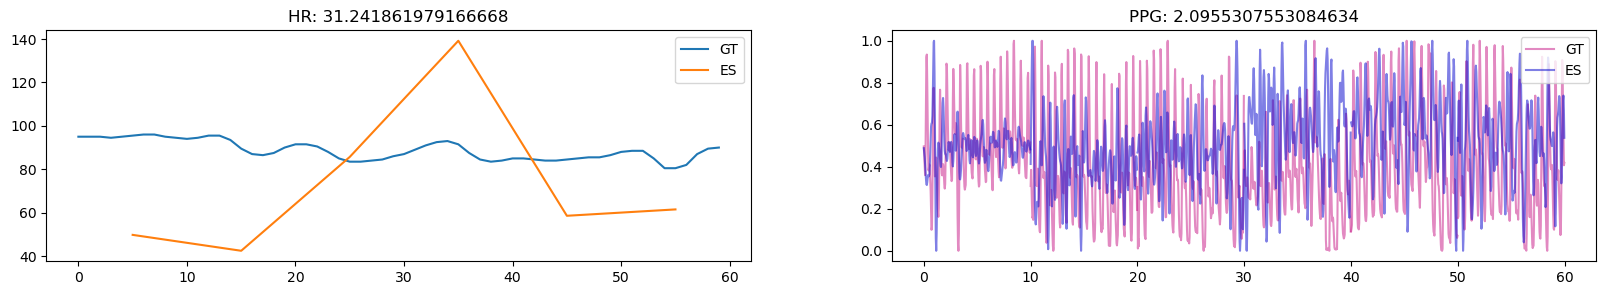

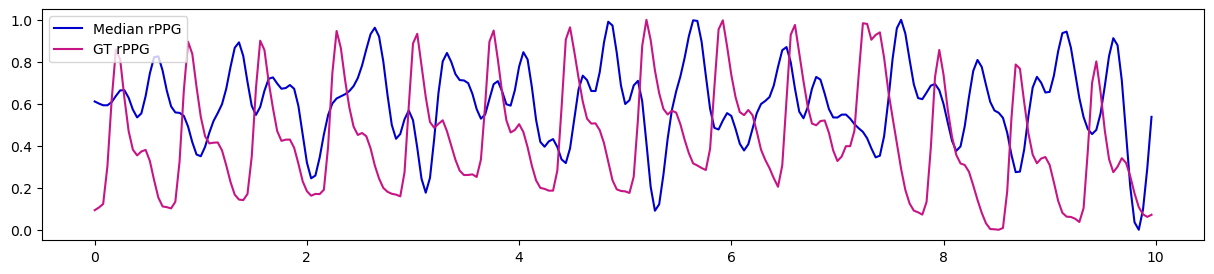

In [16]:
print("VideoFile: ",videoFileName, " landmarks: ", landmarks)  
fig, ax = plt.subplots(1,2,figsize=(20,3))
ax[0].plot(timesGT[:60], bpmGT[:60],label='GT')
ax[0].plot(timesES, bpmES_agg, label='ES')
ax[0].set_title(f'HR: {MAE[0]}')
ax[0].legend()
for w in range(len(BVP_agg)):
    ax[1].plot(np.arange(timesES[w]-timesES.min(), timesES[w]+winsize -timesES.min(), 1/fps), PPG_win[w], alpha=0.5, color='mediumvioletred')
    ax[1].plot(np.arange(timesES[w]-timesES.min(), timesES[w]+winsize -timesES.min(), 1/fps), BVP_agg[w], alpha=0.5, color='mediumblue')
ax[1].plot([], [], label='GT', alpha=0.5, c='mediumvioletred')  
ax[1].plot([], [], label='ES', alpha=0.5, c='mediumblue') 
ax[1].set_title(f'PPG: {dist}')
ax[1].legend()
plt.show()

plt.figure(figsize=(15,3))
w = 4
plt.plot(np.arange(0, winsize, 1/len(BVP_agg[w])*winsize), BVP_agg[w], label='Median rPPG', c='mediumblue')
plt.plot(np.arange(0, winsize, 1/len(BVP_agg[w])*winsize),PPG_win[w], label='GT rPPG', c='mediumvioletred')
plt.legend()

In [19]:
path = f'../results/no_overlap/{dataset_name.upper()}/{config}/'
# path = f'../results/brightness_roi/{brightness}/{dataset_name.upper()}/'
filenames = {'each_28':'28', 'each_18':'18', 'all_in_roi':'entire_ROI', 'combine_random_landmarks':'combine_landmarks', 'combine_roi_landmarks':'landmarks_in_roi', 'combine_roi':'combine_ROI'}

filename = path+f'{dataset_name.upper()}_{filenames[case]}.h5'

print(filename)
df_res.to_hdf(filename, key='df', mode='a')

../results/brightness_roi/LGI_PPGI_28_baseline.h5


C:\Users\erolland\AppData\Local\Temp\2\ipykernel_30008\1017759011.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['dataset', 'videoFilename', 'method', 'landmarks', 'bpmGT', 'bpmES',
       'timeGT', 'timeES', 'BVP_win', 'RMSE', 'MAE', 'PCC', 'SNR', 'ROI',
       'config'],
      dtype='object')]

  df_res.to_hdf(filename, key='df', mode='a')
